In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_confusion_matrix
from sklearn.metrics import r2_score

from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance

from sklearn.impute import SimpleImputer

from category_encoders import OneHotEncoder, OrdinalEncoder

from xgboost import XGBClassifier

from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

from shap import TreeExplainer, initjs, force_plot

import chart_studio
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objs as go
import plotly as ploty

In [2]:
# relative path
data_path = '../../cervical_cancer_project/'
# csv name
csv_file = 'risk_factors_cervical_cancer.csv'

## Wrangle data

In [3]:
def wrangle(filepath):

    df = pd.read_csv(filepath)
    
    # exclude outliers --> older than 55
    df = df[df['Age'] < 55]
    
    # dropping constant columns. Both of these columns all contain only 0
    df.drop(columns = ['STDs:cervical condylomatosis', 'STDs:AIDS'], inplace = True)
    
    # dropping columns with mostly null values (only 71 non-null)
    df.drop(columns = ['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], inplace = True)
    
    # dropping Hinselmann, Schiller, and Citology because all 3 are used to diagnose cervical cancer,
    # meaning they cause data leakage. They are other optional target variables, however, I have chosen
    # Biopsy to be my target
    df.drop(columns = ['Hinselmann', 'Schiller', 'Citology'], inplace = True)
    
    # dropping two rows, where the data is bad --> ages are less than first sexual intercourse
    df.drop(labels = [312, 812], axis = 0, inplace = True)
    
    # replace ? with 'nan' in this column
    df['First sexual intercourse'] = df['First sexual intercourse'].replace('?', 'NaN')
    df = df[df['First sexual intercourse'] != 'NaN']
    df['First sexual intercourse'] = df['First sexual intercourse'].astype(float)
    
    # feature engineer: years sexually active
    # to make this feature, I will drop those who do not specify age of first sexual intercourse
    df['yrs_sexually_active'] = df['Age'] - df['First sexual intercourse']
    
    
    # replace all ? with NaN
    df.replace('?', np.nan, inplace = True)
    
    # change dtype of object columns to float bc all numerical data
    obj_cols = df.select_dtypes('object').columns
    for col in obj_cols:
        df[col] = df[col].astype(float)
        
    return df

In [4]:
data = wrangle(data_path + csv_file)
data.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Biopsy,yrs_sexually_active
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,3.0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,1.0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0.0,0.0,0,1,0,1,0,0,36.0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,25.0
5,42,3.0,23.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,19.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844 entries, 0 to 857
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 844 non-null    int64  
 1   Number of sexual partners           820 non-null    float64
 2   First sexual intercourse            844 non-null    float64
 3   Num of pregnancies                  790 non-null    float64
 4   Smokes                              831 non-null    float64
 5   Smokes (years)                      831 non-null    float64
 6   Smokes (packs/year)                 831 non-null    float64
 7   Hormonal Contraceptives             737 non-null    float64
 8   Hormonal Contraceptives (years)     737 non-null    float64
 9   IUD                                 729 non-null    float64
 10  IUD (years)                         729 non-null    float64
 11  STDs                                740 non-n

<AxesSubplot:>

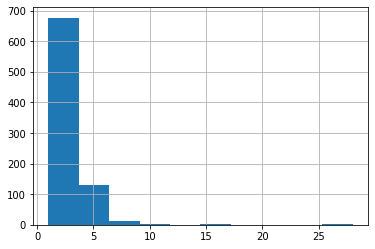

In [6]:
data['Number of sexual partners'].hist()

<AxesSubplot:>

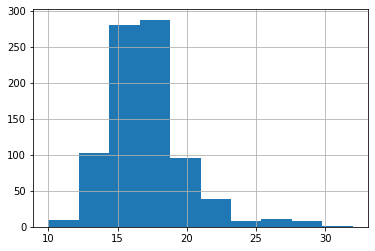

In [7]:
data['First sexual intercourse'].hist()

<AxesSubplot:>

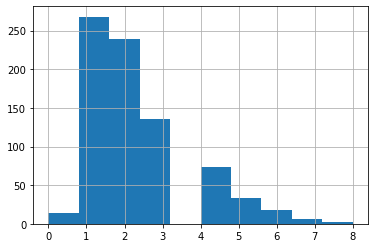

In [8]:
data['Num of pregnancies'].hist()

<AxesSubplot:>

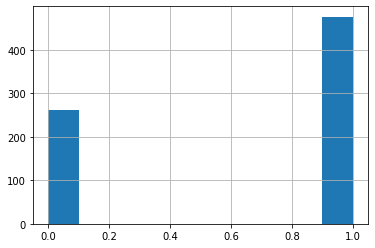

In [9]:
data['Hormonal Contraceptives'].hist()

## Split Data

In [10]:
# Split into fm and tv
X = data.drop(columns = 'Biopsy')
y = data['Biopsy']

In [11]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## Establish Baseline

In [12]:
print('Baseline Accuracy:', y_train.value_counts(normalize = True).max())

Baseline Accuracy: 0.9362962962962963


In [13]:
preds_array = np.array([(y_train.mean())]* len(y_train))
baseline_pred = (preds_array > 0.5).astype(int)
print(classification_report(y_train, baseline_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       632
           1       0.00      0.00      0.00        43

    accuracy                           0.94       675
   macro avg       0.47      0.50      0.48       675
weighted avg       0.88      0.94      0.91       675



# Logistic Regression

### Build Model

In [14]:
lr_model = make_pipeline(SimpleImputer(),
                         LogisticRegression(n_jobs = -1,
                                            random_state = 42))

lr_model.fit(X_train, y_train);

### Check Metrics

In [15]:
cv_scores_lr_score = cross_val_score(lr_model, X_train, y_train, 
                                     n_jobs = -1, 
                                     cv = 10)

print('CV scores Logistic Regression', '\n')
print(cv_scores_lr_score, '\n')
print('Mean CV Accuracy score:', cv_scores_lr_score.mean(), '\n')
print('STD CV Accuracy score:', cv_scores_lr_score.std())

CV scores Logistic Regression 

[0.94117647 0.94117647 0.92647059 0.92647059 0.92647059 0.88059701
 0.94029851 0.94029851 0.94029851 0.94029851] 

Mean CV Accuracy score: 0.9303555750658473 

STD CV Accuracy score: 0.017750562959183123


In [16]:
cv_scores_lr_precision = cross_val_score(lr_model, X_train, y_train, 
                                         n_jobs = -1,
                                         cv = 10,
                                         scoring = 'precision')

print('CV Precision scores Logistic Regression', '\n')
print(cv_scores_lr_precision, '\n')
print('Mean CV Precision score:', cv_scores_lr_precision.mean(), '\n')
print('STD CV Precision score:', cv_scores_lr_precision.std())

CV Precision scores Logistic Regression 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Mean CV Precision score: 0.0 

STD CV Precision score: 0.0


In [17]:
cv_scores_lr_recall = cross_val_score(lr_model, X_train, y_train, 
                                         n_jobs = -1,
                                         cv = 10,
                                         scoring = 'recall')

print('CV Recall scores Logistic Regression', '\n')
print(cv_scores_lr_recall, '\n')
print('Mean CV Recall score:', cv_scores_lr_recall.mean(), '\n')
print('STD CV Recall score:', cv_scores_lr_recall.std())

CV Recall scores Logistic Regression 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Mean CV Recall score: 0.0 

STD CV Recall score: 0.0


### Tune Model

In [18]:
# Set up estimator
estimator_lr = make_pipeline(SimpleImputer(),
                             LogisticRegression(n_jobs = -1,
                        
                                                random_state = 42))
# Want to find best params
params_lr = {'simpleimputer__strategy': ['median', 'mean'],
             'logisticregression__intercept_scaling': np.arange(0.1, 1.1, 0.1),
             'logisticregression__solver': ['liblinear', 'newton-cg', 'lbfgs', 'saga', 'sag']}

# Perform RandomizedSearchCV
model_tune_lr = RandomizedSearchCV(estimator = estimator_lr,
                                param_distributions = params_lr,
                                n_jobs = -1,
                                cv = 10,
                                n_iter = 100,
                                verbose = 4)

# Fit GridSearchCV to train data
model_tune_lr.fit(X_train, y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [19]:
print(model_tune_lr.best_score_)
print(model_tune_lr.best_params_)

0.9363257243195788
{'simpleimputer__strategy': 'median', 'logisticregression__solver': 'saga', 'logisticregression__intercept_scaling': 0.1}


**Tuned Logistic Regression Model**

In [20]:
tuned_lr_model = make_pipeline(SimpleImputer(strategy = 'median'),
                         LogisticRegression(solver = 'saga',
                                            intercept_scaling = 0.1,
                                            n_jobs = -1,
                                            random_state = 42))
tuned_lr_model.fit(X_train, y_train);

### Check Metrics after Tuning Log Regression Model

In [21]:
cv_scores_t_lr_score = cross_val_score(tuned_lr_model, X_train, y_train, 
                                     n_jobs = -1, 
                                     cv = 10)

print('CV scores Tuned Logistic Regression', '\n')
print(cv_scores_t_lr_score, '\n')
print('Mean CV Accuracy score:', cv_scores_t_lr_score.mean(), '\n')
print('STD CV Accuracy score:', cv_scores_t_lr_score.std())

CV scores Tuned Logistic Regression 

[0.94117647 0.94117647 0.92647059 0.92647059 0.92647059 0.94029851
 0.94029851 0.94029851 0.94029851 0.94029851] 

Mean CV Accuracy score: 0.9363257243195788 

STD CV Accuracy score: 0.006460229329953275


In [22]:
cv_scores_t_lr_precision = cross_val_score(tuned_lr_model, X_train, y_train, 
                                         n_jobs = -1,
                                         cv = 10,
                                         scoring = 'precision')

print('CV Precision scores Tuned Logistic Regression', '\n')
print(cv_scores_t_lr_precision, '\n')
print('Mean CV Precision score:', cv_scores_t_lr_precision.mean(), '\n')
print('STD CV Precision score:', cv_scores_t_lr_precision.std())

CV Precision scores Tuned Logistic Regression 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Mean CV Precision score: 0.0 

STD CV Precision score: 0.0


In [23]:
cv_scores_t_lr_recall = cross_val_score(tuned_lr_model, X_train, y_train, 
                                         n_jobs = -1,
                                         cv = 10,
                                         scoring = 'recall')

print('CV Recall scores Tuned Logistic Regression', '\n')
print(cv_scores_t_lr_recall, '\n')
print('Mean CV Recall score:', cv_scores_t_lr_recall.mean(), '\n')
print('STD CV Recall score:', cv_scores_t_lr_recall.std())

CV Recall scores Tuned Logistic Regression 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Mean CV Recall score: 0.0 

STD CV Recall score: 0.0


# Random Forest

In [24]:
rf_model = make_pipeline(SimpleImputer(),
                         RandomForestClassifier(n_jobs = -1,
                                                random_state = 42))

rf_model.fit(X_train, y_train);

### Check Metrics

In [25]:
cv_scores_rf_score = cross_val_score(rf_model, X_train, y_train, 
                                     n_jobs = -1, 
                                     cv = 10)

print('CV scores RandomForest', '\n')
print(cv_scores_rf_score, '\n')
print('Mean CV Accuracy score:', cv_scores_rf_score.mean(), '\n')
print('STD CV Accuracy score:', cv_scores_rf_score.std())

CV scores RandomForest 

[0.94117647 0.95588235 0.91176471 0.94117647 0.92647059 0.91044776
 0.94029851 0.92537313 0.94029851 0.94029851] 

Mean CV Accuracy score: 0.9333187006145742 

STD CV Accuracy score: 0.01369833508426236


In [26]:
cv_scores_rf_precision = cross_val_score(rf_model, X_train, y_train, 
                                         n_jobs = -1,
                                         cv = 10,
                                         scoring = 'precision')

print('CV Precision scores RandomForest', '\n')
print(cv_scores_rf_precision, '\n')
print('Mean CV Precision score:', cv_scores_rf_precision.mean(), '\n')
print('STD CV Precision score:', cv_scores_rf_precision.std())

CV Precision scores RandomForest 

[0.5 1.  0.  1.  0.  0.  0.  0.  0.  0. ] 

Mean CV Precision score: 0.25 

STD CV Precision score: 0.4031128874149275


In [27]:
cv_scores_rf_recall = cross_val_score(rf_model, X_train, y_train, 
                                         n_jobs = -1,
                                         cv = 10,
                                         scoring = 'recall')

print('CV Recall scores RandomForest', '\n')
print(cv_scores_rf_recall, '\n')
print('Mean CV Recall score:', cv_scores_rf_recall.mean(), '\n')
print('STD CV Recall score:', cv_scores_rf_recall.std(), '\n')

CV Recall scores RandomForest 

[0.25 0.25 0.   0.2  0.   0.   0.   0.   0.   0.  ] 

Mean CV Recall score: 0.06999999999999999 

STD CV Recall score: 0.10770329614269007 



### Tune Model

In [30]:
# Set up estimator
estimator = make_pipeline(SimpleImputer(),
                          RandomForestClassifier(n_jobs = -1,
                                                 random_state=42))

# Want to find best params
params = {'simpleimputer__strategy': ['median', 'mean'],
          'randomforestclassifier__n_estimators': range(45, 225, 5),
          'randomforestclassifier__max_depth': range(18, 22, 1),
          'randomforestclassifier__max_features': np.arange(0.2, 0.91, 0.05)}

# Perform RandomizedSearchCV
model_tune = RandomizedSearchCV(estimator = estimator,
                                param_distributions = params,
                                n_jobs = -1,
                                cv = 10,
                                n_iter = 100,
                                verbose = 4)

# Fit GridSearchCV to train data
model_tune.fit(X_train, y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [29]:
print(model_tune.best_score_)
print(model_tune.best_params_)

0.9392449517120282
{'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 175, 'randomforestclassifier__max_features': 0.8499999999999999, 'randomforestclassifier__max_depth': 20}


**Tuned RandomForest Model**

In [32]:
tuned_rf_model = make_pipeline(SimpleImputer(strategy = 'median'),
                               RandomForestClassifier(n_estimators = 175,
                                                      max_depth = 20,
                                                      max_features = 0.85,
                                                      n_jobs = -1,
                                                      random_state=42))

tuned_rf_model.fit(X_train, y_train);

### Check Metrics of Tuned  RandomForest Model

In [33]:
cv_scores_tuned_rf_score = cross_val_score(tuned_rf_model, X_train, y_train, 
                                     n_jobs = -1, 
                                     cv = 10)

print('CV scores Tuned RandomForest', '\n')
print(cv_scores_tuned_rf_score, '\n')
print('Mean CV Accuracy score:', cv_scores_tuned_rf_score.mean(), '\n')
print('STD CV Accuracy score:', cv_scores_tuned_rf_score.std())

CV scores Tuned RandomForest 

[0.94117647 0.95588235 0.92647059 0.94117647 0.94117647 0.94029851
 0.94029851 0.92537313 0.94029851 0.94029851] 

Mean CV Accuracy score: 0.9392449517120282 

STD CV Accuracy score: 0.00805013673056356


In [34]:
cv_scores_tuned_rf_precision = cross_val_score(tuned_rf_model, X_train, y_train, 
                                         n_jobs = -1,
                                         cv = 10,
                                         scoring = 'precision')

print('CV Precision scores Tuned RandomForest', '\n')
print(cv_scores_tuned_rf_precision, '\n')
print('Mean CV Precision score:', cv_scores_tuned_rf_precision.mean(), '\n')
print('STD CV Precision score:', cv_scores_tuned_rf_precision.std())

CV Precision scores Tuned RandomForest 

[0.5 1.  0.  1.  1.  0.  0.5 0.  0.  0. ] 

Mean CV Precision score: 0.4 

STD CV Precision score: 0.4358898943540674


In [35]:
cv_scores_tuned_rf_recall = cross_val_score(tuned_rf_model, X_train, y_train, 
                                         n_jobs = -1,
                                         cv = 10,
                                         scoring = 'recall')

print('CV Recall scores Tuned RandomForest', '\n')
print(cv_scores_tuned_rf_recall, '\n')
print('Mean CV Recall score:', cv_scores_tuned_rf_recall.mean(), '\n')
print('STD CV Recall score:', cv_scores_tuned_rf_recall.std(), '\n')

CV Recall scores Tuned RandomForest 

[0.25 0.25 0.   0.2  0.2  0.   0.25 0.   0.   0.  ] 

Mean CV Recall score: 0.11499999999999999 

STD CV Recall score: 0.11629703349613008 



# XGB Classifier

In [36]:
xgb_model = make_pipeline(SimpleImputer(),
                          XGBClassifier(use_label_encoder = False,
                                        random_state = 42,
                                        n_jobs = -1))

xgb_model.fit(X_train, y_train);

[21:19:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Check Metrics

In [37]:
cv_scores_xgb_score = cross_val_score(xgb_model, X_train, y_train, 
                                     n_jobs = -1, 
                                     cv = 10)

print('CV scores XGB', '\n')
print(cv_scores_xgb_score, '\n')
print('Mean CV Accuracy score:', cv_scores_xgb_score.mean(), '\n')
print('STD CV Accuracy score:', cv_scores_xgb_score.std())

CV scores XGB 

[0.94117647 0.95588235 0.91176471 0.92647059 0.92647059 0.92537313
 0.91044776 0.95522388 0.92537313 0.91044776] 

Mean CV Accuracy score: 0.9288630377524145 

STD CV Accuracy score: 0.01607159703431623


In [38]:
cv_scores_xgb_precision = cross_val_score(xgb_model, X_train, y_train, 
                                         n_jobs = -1,
                                         cv = 10,
                                         scoring = 'precision')

print('CV Precision scores XGB', '\n')
print(cv_scores_xgb_precision, '\n')
print('Mean CV Precision score:', cv_scores_xgb_precision.mean(), '\n')
print('STD CV Precision score:', cv_scores_xgb_precision.std())

CV Precision scores XGB 

[0.5  1.   0.   0.   0.   0.   0.25 1.   0.   0.  ] 

Mean CV Precision score: 0.275 

STD CV Precision score: 0.3944933459514875


In [39]:
cv_scores_xgb_recall = cross_val_score(xgb_model, X_train, y_train, 
                                         n_jobs = -1,
                                         cv = 10,
                                         scoring = 'recall')

print('CV Recall scores XGB', '\n')
print(cv_scores_xgb_recall, '\n')
print('Mean CV Recall score:', cv_scores_xgb_recall.mean(), '\n')
print('STD CV Recall score:', cv_scores_xgb_recall.std(), '\n')

CV Recall scores XGB 

[0.25 0.25 0.   0.   0.   0.   0.25 0.25 0.   0.  ] 

Mean CV Recall score: 0.1 

STD CV Recall score: 0.12247448713915891 



### Tune Model

In [51]:
# Set up estimator
estimator_1 = make_pipeline(SimpleImputer(),
                            XGBClassifier(use_label_encoder = False, 
                                          n_jobs = -1, 
                                          random_state=42))

# Want to find best params
params_1 = {'simpleimputer__strategy': ['mean', 'median'],
            'xgbclassifier__max_depth': range(2, 42, 2),
            'xgbclassifier__eta': np.arange(0.1, 1.1, 0.1),
            'xgbclassifier__reg_lambda': range(3, 14, 2)}

# Perform RandomizedSearchCV
model_tune_1 = RandomizedSearchCV(estimator = estimator_1, 
                                  param_distributions = params_1, 
                                  n_jobs = -1,
                                  cv = 5,
                                  n_iter = 25,
                                  verbose = 6)

# Fit RandomizedSearchCV to train data
model_tune_1.fit(X_train, y_train);

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[21:53:37] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [48]:
print(model_tune_1.best_params_)
print(model_tune_1.best_score_)

{'xgbclassifier__reg_lambda': 3, 'xgbclassifier__max_depth': 22, 'xgbclassifier__eta': 0.6, 'simpleimputer__strategy': 'median'}
0.9362962962962962


**Tuned XGB Classifier Model**

In [59]:
tuned_xgb_model = make_pipeline(SimpleImputer(strategy = 'median'),
                                XGBClassifier(eta = 0.6,
                                              reg_lambda = 3,
                                              max_depth = 22,
                                              use_label_encoder = False,
                                              n_jobs = -1,
                                              random_state = 42))

tuned_xgb_model.fit(X_train, y_train);

[21:57:35] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Check Metrics of Tuned XGB

In [60]:
cv_scores_tuned_xgb_score = cross_val_score(tuned_xgb_model, X_train, y_train, 
                                     n_jobs = -1, 
                                     cv = 10)

print('CV scores Tuned XGB', '\n')
print(cv_scores_tuned_xgb_score, '\n')
print('Mean CV Accuracy score:', cv_scores_tuned_xgb_score.mean(), '\n')
print('STD CV Accuracy score:', cv_scores_tuned_xgb_score.std())

CV scores Tuned XGB 

[0.92647059 0.95588235 0.91176471 0.94117647 0.91176471 0.92537313
 0.91044776 0.97014925 0.92537313 0.94029851] 

Mean CV Accuracy score: 0.9318700614574189 

STD CV Accuracy score: 0.01892214228334211


In [61]:
cv_scores_tuned_xgb_precision = cross_val_score(tuned_xgb_model, X_train, y_train, 
                                         n_jobs = -1,
                                         cv = 10,
                                         scoring = 'precision')

print('CV Precision scores Tuned XGB', '\n')
print(cv_scores_tuned_xgb_precision, '\n')
print('Mean CV Precision score:', cv_scores_tuned_xgb_precision.mean(), '\n')
print('STD CV Precision score:', cv_scores_tuned_xgb_precision.std())

CV Precision scores Tuned XGB 

[0.33333333 1.         0.         1.         0.         0.
 0.         1.         0.         0.        ] 

Mean CV Precision score: 0.3333333333333333 

STD CV Precision score: 0.4472135954999579


In [62]:
cv_scores_tuned_xgb_recall = cross_val_score(tuned_xgb_model, X_train, y_train, 
                                         n_jobs = -1,
                                         cv = 10,
                                         scoring = 'recall')

print('CV Recall scores Tuned XGB', '\n')
print(cv_scores_tuned_xgb_recall, '\n')
print('Mean CV Recall score:', cv_scores_tuned_xgb_recall.mean(), '\n')
print('STD CV Recall score:', cv_scores_tuned_xgb_recall.std(), '\n')

CV Recall scores Tuned XGB 

[0.25 0.25 0.   0.2  0.   0.   0.   0.5  0.   0.  ] 

Mean CV Recall score: 0.12 

STD CV Recall score: 0.1646207763315433 



# Comparing Models

In [64]:
models = [lr_model, tuned_lr_model, rf_model, tuned_rf_model, xgb_model, tuned_xgb_model]
model_names = ['Logistic Regression', 'Tuned Logistic Regression','RandomForest', 
               'Tuned RandomForest', 'XGB Classifier', 'Tuned XGB Classifier']

rocauc_no_oversamp = go.Figure()
rocauc_no_oversamp.add_shape(type = 'line',
                           line = dict(dash = 'dash'),
                           x0 = 0, x1 = 1, y0 = 0, y1 =1)
for model, name in zip(models, model_names):
    y_pred = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_score = np.round(roc_auc_score(y_test, y_pred), 3)
    
    model_name = name
    name = f"{model_name} (ROC_AUC = {auc_score})"
    rocauc_no_oversamp.add_trace(go.Scatter(x = fpr, y = tpr, name = name, mode = 'lines'))

    
    
rocauc_no_oversamp.update_layout(xaxis_title = 'False Positive Rate',
                                   yaxis_title = 'True Positive Rate',
                                   title = 'ROC Curve of Models Predicting Cervical Cancer',
                                   width = 900,
                                   height = 500)

rocauc_no_oversamp.show()

# Results

In [65]:
print('Baseline Accuracy:', y_train.value_counts(normalize = True).max())

Baseline Accuracy: 0.9362962962962963


In [66]:
print('Accuracy Tuned Logistic Regression on Test Data:', tuned_lr_model.score(X_test, y_test), '\n')
print('Accuracy Logistic Regression on Test Data:', lr_model.score(X_test, y_test), '\n')
print('Accuracy Tuned Random Forest on Test Data:', tuned_rf_model.score(X_test, y_test), '\n')
print('Accuracy Random Forest on Test Data:', rf_model.score(X_test, y_test), '\n')
print('Accuracy Tuned XGB Classifier on Test Data:', tuned_xgb_model.score(X_test, y_test), '\n')
print('Accuracy XGB Classifier on Test Data:', xgb_model.score(X_test, y_test), '\n')

Accuracy Tuned Logistic Regression on Test Data: 0.9289940828402367 

Accuracy Logistic Regression on Test Data: 0.9230769230769231 

Accuracy Tuned Random Forest on Test Data: 0.9053254437869822 

Accuracy Random Forest on Test Data: 0.9171597633136095 

Accuracy Tuned XGB Classifier on Test Data: 0.9171597633136095 

Accuracy XGB Classifier on Test Data: 0.9053254437869822 



In [67]:
# predictions with tuned lr model for test set
tuned_lr_model_test_pred = (tuned_lr_model.predict_proba(X_test)[:, 1] > 0.2).astype(int)

# calculate recall and precision for model\
print('Tuned Logistic Regression')
print(classification_report(y_test, tuned_lr_model_test_pred))

Tuned Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       157
           1       0.00      0.00      0.00        12

    accuracy                           0.92       169
   macro avg       0.46      0.49      0.48       169
weighted avg       0.86      0.92      0.89       169



In [68]:
# predictions with lr model for test set
lr_model_test_pred = (lr_model.predict_proba(X_test)[:, 1] > 0.2).astype(int)

# calculate recall and precision for model\
print(' Logistic Regression')
print(classification_report(y_test, lr_model_test_pred))

 Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       157
           1       0.10      0.08      0.09        12

    accuracy                           0.88       169
   macro avg       0.52      0.51      0.51       169
weighted avg       0.87      0.88      0.88       169



In [69]:
# predictions with rf model for test set
rf_model_test_pred = (rf_model.predict_proba(X_test)[:, 1] > 0.2).astype(int)

# calculate recall and precision for model\
print('RandomForest Classifier')
print(classification_report(y_test, rf_model_test_pred))

RandomForest Classifier
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       157
           1       0.14      0.17      0.15        12

    accuracy                           0.87       169
   macro avg       0.54      0.55      0.54       169
weighted avg       0.88      0.87      0.87       169



In [70]:
# predictions with tuned xgb model for test set
t_xgb_model_test_pred = (tuned_xgb_model.predict_proba(X_test)[:, 1] > 0.2).astype(int)

# calculate recall and precision for model\
print('Tuned XGB Classifier')
print(classification_report(y_test, t_xgb_model_test_pred))

Tuned XGB Classifier
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       157
           1       0.00      0.00      0.00        12

    accuracy                           0.87       169
   macro avg       0.46      0.47      0.47       169
weighted avg       0.86      0.87      0.86       169



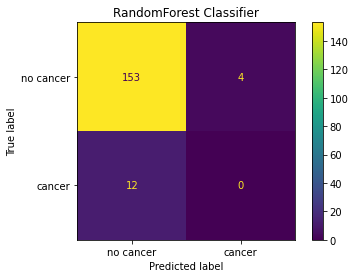

In [71]:
# confusion matrix of model
plot_confusion_matrix(
    tuned_rf_model,
    X_test, 
    y_test,
    display_labels=['no cancer', 'cancer']
)

plt.title('RandomForest Classifier');

In [72]:
thresholds = np.arange(0.1, 1.0, 0.05)

accuracy_scores = []
precision_scores = []
recall_scores = []

score_plot = go.Figure()

for threshold in thresholds:
    # make predictions at each threshold
    y_pred = (rf_model.predict_proba(X_test)[:, 1] > threshold).astype(int)
    
    # calculate accuracy, precision, and recall for each threshold's predictions
    accuracy = accuracy_score(y_test, y_pred)*100
    precision = precision_score(y_test, y_pred)*100
    recall = recall_score(y_test, y_pred)*100
    
    # append the scores to their respective lists
    accuracy_scores = np.append(accuracy_scores, accuracy)
    precision_scores = np.append(precision_scores, precision)
    recall_scores = np.append(recall_scores, recall)
    
score_plot.add_trace(go.Scatter(x = thresholds, y = accuracy_scores, name = 'Accuracy', mode = 'lines')) 
score_plot.add_trace(go.Scatter(x = thresholds, y = precision_scores, name = 'Precision', mode = 'lines'))
score_plot.add_trace(go.Scatter(x = thresholds, y = recall_scores, name = 'Recall', mode = 'lines'))

score_plot.update_layout(xaxis_title = 'Cutoff Threshold',
                         yaxis_title = 'Score (%)',
                         title = 'Performance Metrics with RandomForest Classifier')

# Communicate Results

In [73]:
importances = rf_model.named_steps['randomforestclassifier'].feature_importances_

importances_df = pd.DataFrame({'importances': importances},
                              index = X_test.columns).sort_values(by = 'importances')

importances_top_10 = importances_df.tail(10)

feat_imps = px.bar(importances_top_10, 
                            x = 'importances',
                            labels = dict(importances = 'Feature Importance',
                                          index = 'Feature'),
                            title = 'Feature Importances of RandomForest Classifier')
feat_imps.show()

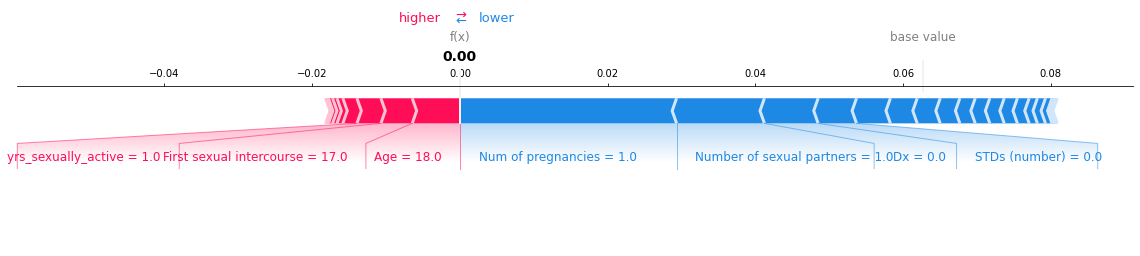

In [81]:
chosen_instance = X_test.loc[[356]]

si = SimpleImputer()

X_train_T = si.fit_transform(X_train)

randomforest = RandomForestClassifier(n_jobs = -1, random_state = 42)

randomforest.fit(X_train_T, y_train)

explainer = TreeExplainer(randomforest)

shap_values = explainer.shap_values(chosen_instance)

initjs()

neg_case = force_plot(base_value = explainer.expected_value[1],
                               shap_values = shap_values[1],
                               features = chosen_instance,
                               show = False,
                               matplotlib = True)

neg_case.savefig('neg_case.jpg', pad_inches=2, bbox_inches='tight')

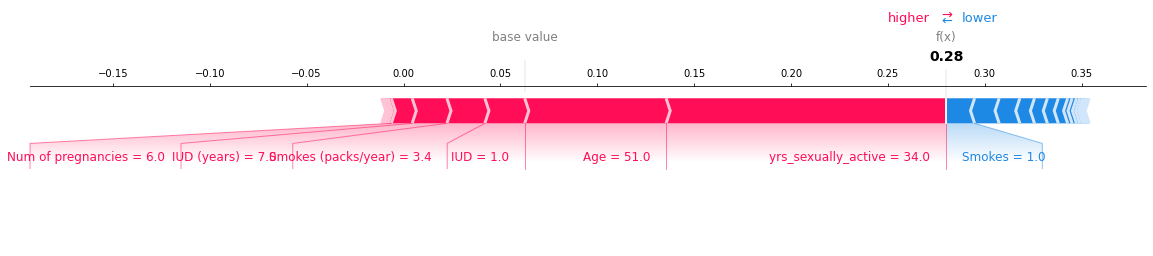

In [82]:
chosen_instance = X_test.loc[[6]]

si = SimpleImputer()

X_train_T = si.fit_transform(X_train)

randomforest = RandomForestClassifier(n_jobs = -1, random_state = 42)

randomforest.fit(X_train_T, y_train)

explainer = TreeExplainer(randomforest)

shap_values = explainer.shap_values(chosen_instance)

initjs()

pos_case = force_plot(base_value = explainer.expected_value[1],
                               shap_values = shap_values[1],
                               features = chosen_instance,
                               show = False,
                               matplotlib = True)
                                   
pos_case.savefig('pos_case.jpg', pad_inches = 2, bbox_inches = 'tight')

# Save Charts in Plotly

In [83]:
username = 'keilayb'
api_key = 'LPu5Ft3DuIF8ek1Svxbq'

chart_studio.tools.set_credentials_file(username = username, api_key = api_key)

py.plot(rocauc_no_oversamp, filename = 'rocauc_no_oversamp', auto_open = True)

'https://plotly.com/~keilayb/29/'

In [84]:
py.plot(score_plot, filename = 'score_plot', auto_open = True)

'https://plotly.com/~keilayb/31/'

In [85]:
py.plot(feat_imps, filename = 'feat_imps', auto_open = True)

'https://plotly.com/~keilayb/33/'